In [2]:
import torch
import geomstats
import geomstats.backend as gs
from geomstats.geometry.spd_matrices import *
from geomstats.geometry.stiefel import Stiefel
from geomstats.datasets.utils import load_connectomes
from geomstats.visualization.spd_matrices import Ellipses
from shape_vis import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla

# Learning distributions of healthy & schizophrenic brain shapes via denoising diffusion on manifolds.
## Authors: Marianne Arriola & Ryan Stofer

### Introduction and Background:

*INSERT BACKGROUND INFO HERE*

### Model Architecture:

*INSERT MODEL ARCHITECTURE INFO HERE*

### Data:

*INSERT DATA INFO HERE*

In [11]:
data, ids, target = load_connectomes()
print(data.shape)
print(ids)
print(target)

spd = SPDMatrices(28)
spd_affine = SPDBuresWassersteinMetric(28)

(86, 28, 28)
[120873 135376 139149 146791 153870 167403 179564 179614 180172 191161
 197297 199397 216806 222333 224755 244353 259678 267327 273218 273762
 275939 277945 290112 293046 295807 298608 323839 337260 348851 403692
 404156 427131 427246 438939 441598 459624 467185 468228 468930 469535
 472665 474861 479741 495307 508321 522766 529803 537342 542571 558698
 559296 570576 573811 581828 582211 597203 609291 617191 641748 702920
 712549 737494 752943 767901 774591 775909 794470 797181 806111 818142
 823981 829335 835522 862050 867297 879556 906283 907482 909442 932646
 933065 934330 950671 963924 993348 993946]
[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 1]


In [12]:
bool_list = list(map(bool,target))
flip_bool_list = [not elem for elem in bool_list]
schiz = data[bool_list]
print(schiz.shape)
schiz_spd = spd.projection(schiz)
healthy = data[flip_bool_list]
print(healthy.shape)
healthy_spd = spd.projection(healthy)

(40, 28, 28)
(46, 28, 28)


### Noise Scheduler

In [109]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return gs.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, shape, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = np.random.standard_normal(shape)
    # mean + variance
    return sqrt_alphas_cumprod[t] * x_0 \
    + sqrt_one_minus_alphas_cumprod[t] * noise, noise


# Define beta schedule
T = 10
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = gs.cumprod(alphas, axis=0)
alphas_cumprod_prev = gs.pad(alphas_cumprod[:-1], (1, 0))
alphas_cumprod_prev[0] = 1
sqrt_recip_alphas = gs.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = gs.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = gs.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

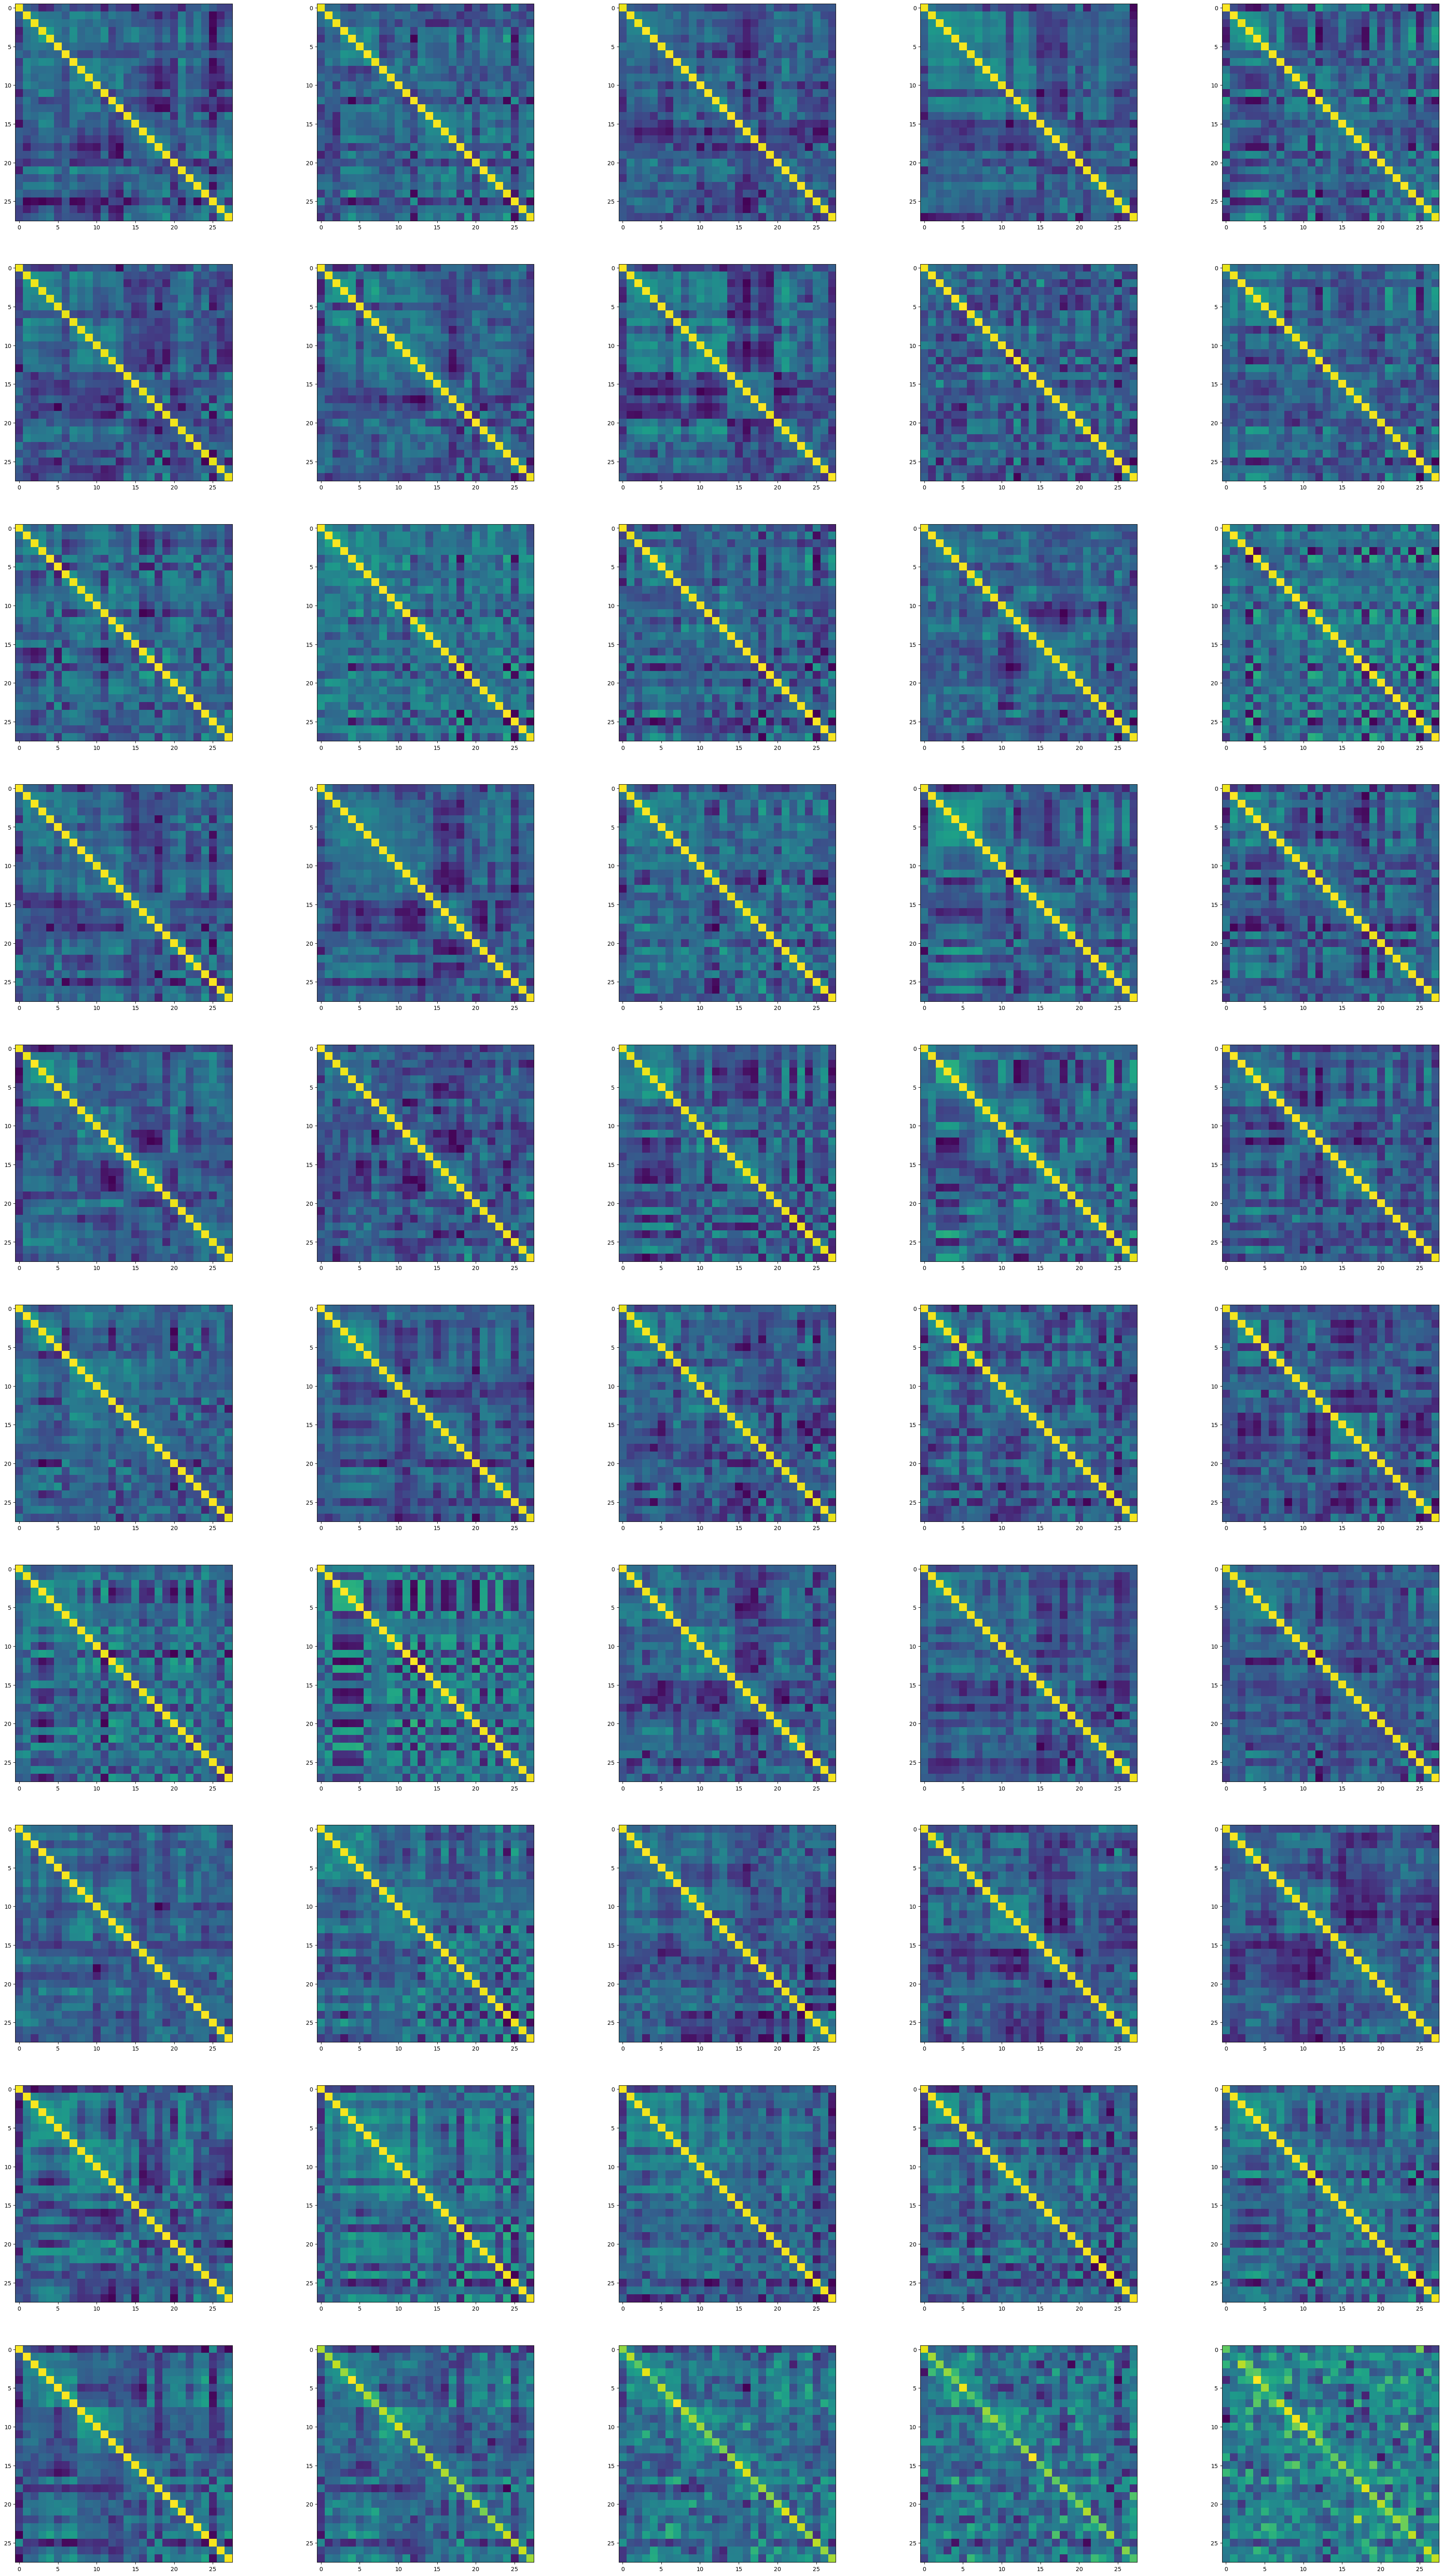

In [117]:
num_images = 5
stepsize = int(T/num_images)
fig = plt.figure(figsize=(len(healthy), len(healthy)*num_images))
for i, data in enumerate(healthy):
    for idx in range(0, T, stepsize):
        t = idx
        plt.subplot(len(data), num_images, int((idx/stepsize)+1+i))
        image, noise = forward_diffusion_sample(data, data.shape, t)
        plt.imshow(image)

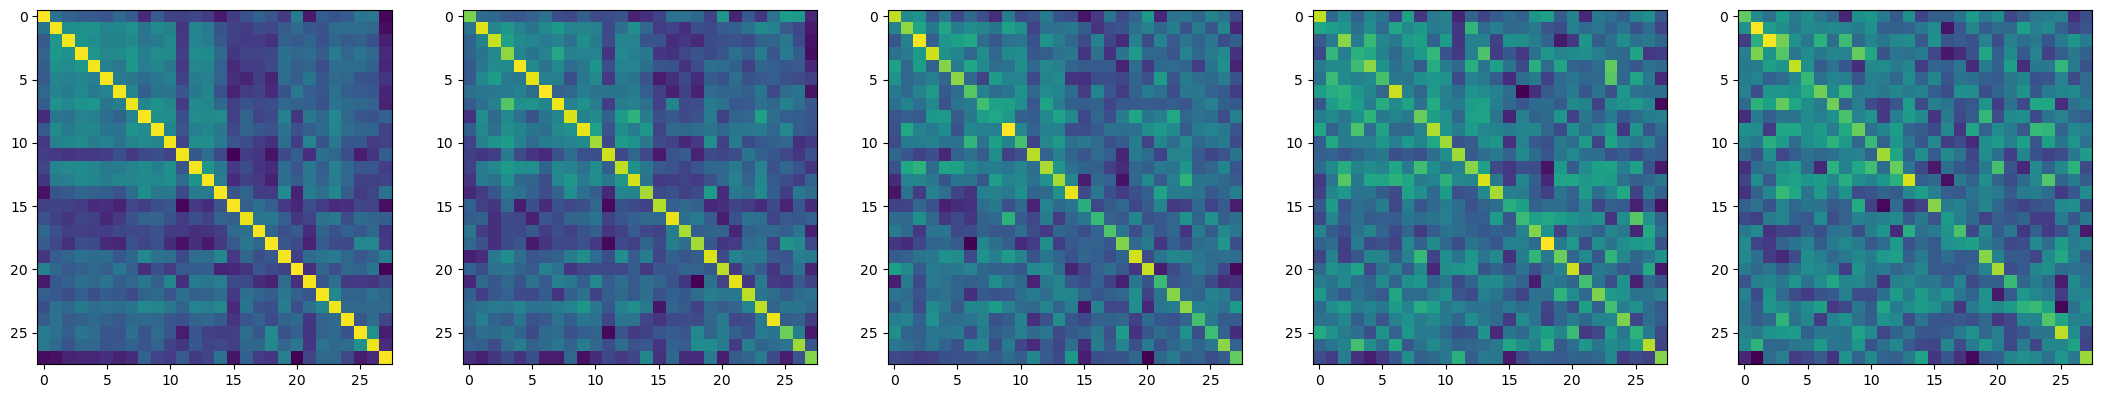

In [125]:
## Example forward diffusion process
fig = plt.figure(figsize=(32,32))
for idx in range(0, T, stepsize):
    t = idx
    plt.subplot(1, num_images+1, int((idx/stepsize)+1))
    image, noise = forward_diffusion_sample(healthy[3], healthy[3].shape, t)
    plt.imshow(image)

Sources:
- Diffusion Model Tutorial: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=uuckjpW_k1LN